In [2]:
# ESSENTIALS
import numpy as np
import matplotlib.pyplot as plt
import glob, os

# CLUSTERING AND RANDOM FOREST
import skfuzzy as fuzz
from sklearn import tree
from sklearn import model_selection
from sklearn.datasets import make_blobs
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
from sklearn.svm import *
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# DATA LIBRARIES
import rasterio
import contextily as cx
import geopandas as gpd
import pandas as pd


# PREFERENCES
pd.set_option('display.max_columns', 500)
# plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (15, 15)
plt.rcParams.update({'font.size': 14})

ImportError: DLL load failed while importing _version: The specified module could not be found.

Define our Scikit-Learn Compliant Class so we can implement validation schemes within. Only two methods required: predict() and fit()

In [2]:
class ModelSelector():

    def __init__(self, c_kwargs={}, rf_kwargs={}):
       self.c_kwargs=c_kwargs        # CLUSTERING HYPERPARAMETERS
       self.rf_kwargs=rf_kwargs      # RANDOM FOREST HYPERPARAMETERS
       self.m = 2                    # EXPONENTIATION COEFFICIENT FOR CLUSTERING. TODO: MAKE ADJUSTABLE

    def fuzzyCluster(self, data):
        # Wraps Fuzzy Cluster function, only outputting percent belongs and formal cluster.

        # CHECK THAT REQUIRED FIELDS ARE IN KWARGS, IF NOT ADD
        if "error" not in self.c_kwargs:
            self.c_kwargs['error']=0.005

        if "maxiter" not in self.c_kwargs:
            self.c_kwargs['maxiter']=1000

        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data.T, self.n_centers, self.m, **self.c_kwargs)
        label = np.argmax(u, axis=0)
        return cntr, u, fpc, label

    def howManyClusters(self, X, mintest=2,maxtest=15):
        # Determines how many clusters should be used using the Fuzzy Partitions Coefficient (FPC)
        # https://scikit-fuzzy.github.io/scikit-fuzzy/auto_examples/plot_cmeans.html#example-plot-cmeans-py
        # TODO: FIGURE OUT IF THIS METHOD IS APPROPRIATE OR NOT
        return 3
        fpcs = []
        listtests = np.arange(mintest,maxtest)
        for ncenters in listtests:
            self.n_centers = ncenters
            _, _, fpc, _ = self.fuzzyCluster(X)
            fpcs.append(fpc)
        return listtests[np.argmax(fpcs)]

    def train_rf(self, X_train, y_train, rf_controls={}):
        # ADAPTED FROM https://stackoverflow.com/questions/28489667/combining-random-forest-models-in-scikit-learn

        # RF CONTROLS PASSED DIRECTLY FROM PARAMETER, DEFAULT IS EMPTY
        rf = RandomForestRegressor(**rf_controls) 

        # RF FITTING 
        rf.fit(X_train, y_train)

        return rf

    def fit(self, attributes, model_perf):

        # CREATE RANDOM FOREST AND TRAIN
        self.rf = self.train_rf(attributes, model_perf, rf_controls=self.rf_kwargs)
        # print(r2_score(self.rf.predict(attributes), model_perf))

        return self

    def predict(self, attributes):

        # CHECK WHETHER MODEL HAS BEEN TRAINED
        if self.rf is None:
            raise(Exception("ModelSelector isn't trained!"))

        # GET RANDOM FOREST PREDICTION
        pred = self.rf.predict(attributes)


        return pred


Define function to get values from Random Forest

In [3]:
def runFitMetric_getMSE(fitmet, rf_kwargs={}):
    # FILEPATH TO SHAPEFILE CONTAINING CAMELS DATASET
    camelsdir = r"C:\Users\franc\OneDrive - University Of Houston\000_SIResearch\data\HCDN_nhru_final\HCDN_nhru_final_671.shp"

    # DIRECTORY TO FOLDER CONTAINING CAMELS ATTRIBUTE TEXTFILES
    # PRIOR TO THIS STEP MAKE SURE THE README IN THE FILE SYSTEM HAS BEEN REMOVED (or the file extension has been changed)
    attdir = r"C:\Users\franc\OneDrive - University Of Houston\000_SIResearch\data\camels_attributes_v2.0\camels_attributes_v2.0\\"

    # READ CAMELS DATASET
    camels = gpd.read_file(camelsdir)

    # COPY TO KEEP ORIGINAL IN MEMORY
    camels_df = camels 

    # LOOP THROUGH AND JOIN
    filelist = glob.glob(attdir + "*.txt")
    for i in filelist:
        currdf = pd.read_csv(i, sep=";")
        camels_df = camels_df.merge(currdf, how='left', left_on="hru_id", right_on="gauge_id")

    # DEFINE WHAT WE WANT TO RUN ON
    perf_dir = r"C:\Users\franc\OneDrive - University Of Houston\000_SIResearch\data\hourly_performances\\"
    
    perf_metrics = [fitmet]

    # READ ALL CSV FILES IN DIRECTORY
    os.chdir(perf_dir)
    modelfiles = glob.glob("*.csv")

    # GET FIRST CSV FILE TO DEFINE DATAFRAME AND ADD PREFIX TO COLUMNS BASED ON NAME
    print(perf_dir + modelfiles[0])
    perf = pd.read_csv(perf_dir + modelfiles[0]).add_prefix(modelfiles[0][:-4] + "_")
    # GET COLUMN NAME CONTAINING "BASIN"
    fcol = [col for col in perf.columns if 'basin' in col]

    # LOOP FOR EACH CSV FILE
    for ii in range(1, len(modelfiles)):
        print(perf_dir + modelfiles[ii])
        # GET NEXT CSV FILE TO DEFINE DATAFRAME AND ADD PREFIX TO COLUMNS BASED ON NAME
        currdf = pd.read_csv(perf_dir + modelfiles[ii]).add_prefix(modelfiles[ii][:-4] + "_")

        # GET COLUMN NAME CONTAINING "BASIN"
        basin_col= [col for col in currdf.columns if 'basin' in col]
        # JOIN ON MATCHING BASINS
        perf = perf.merge(currdf, how="inner", left_on=fcol, right_on=basin_col)

    # GET COLUMN NAME CONTAINING "FITMET"
    perf_met = [col for col in perf.columns if fitmet in col]

    # CLEAN UP NONSENSICAL DATA (EG, BASIN LABELS)
    # SO LETS GET A LIST OF VARIABLE NAMES WE WANT TO KEEP.

    # TO START WE WILL KEEP THE SAME VARIABLES AS Kratzert et al. 2019, AS SHOWN BY OUR
    # INTERNAL SPREADSHEET Attributes_CAMELS_vs_NHDPlus
    varstokeep = ['organic_frac',
    'elev_mean_x',
    'slope_mean',
    'area_gages2',
    'soil_depth_pelletier',
    'sand_frac',
    'silt_frac',
    'clay_frac',
    'geol_permeability',
    'p_mean',
    'pet_mean',
    'aridity',
    'frac_snow',
    'high_prec_freq',
    'high_prec_dur',
    'low_prec_freq',
    'low_prec_dur']

    camels_df = camels_df.merge(perf, how="inner", left_on="hru_id", right_on=fcol)
    inputdataset = camels_df[varstokeep]
    outputdataset = camels_df[perf_met]
    
    
    nsplits = 5
    kf = KFold(n_splits=nsplits, shuffle=True)


    testvalues = np.zeros((inputdataset.shape[0], outputdataset.shape[1]))                  # CONTAINER FOR PERFORMANCE VALUES WHEN BASIN IN TEST SET
    modelno = 0                                                              # COUNTER FOR MODEL CONTAINER
    test_modelno = np.zeros((inputdataset.shape[0], outputdataset.shape[1]))                # MODEL IN WHICH BASIN WAS IN TEST SET
    test_modellist = list()                                                  # MODEL CONTAINER
    featureimportance = list()
    msetest = list()
    msetrain = list()
    msemeta = list()

    currout=outputdataset

    # KFOLD SPLIT OF DATASETS
    for train, test in kf.split(inputdataset):            
        # CODE FOR INDIVIDUAL MODEL TRAINING
        for ii in range(currout.shape[1]):
            # TRAIN MODEL ON TRAINING SET
            model = None
            model = ModelSelector(rf_kwargs=rf_kwargs)
            model.fit(inputdataset.iloc[train, :], currout.iloc[train, ii])

            # PERFORM PREDICTION ON TRAIN SET AND GET FIT METRICS
            train_pred = model.predict(inputdataset.iloc[train, :])
            trainrms = mse(train_pred, currout.iloc[train, ii].to_numpy())
            trainr2 = r2_score(train_pred, currout.iloc[train, ii].to_numpy())

            # PERFORM PREDICTION ON TEST SET AND GET FIT METRICS
            model_pred = model.predict(inputdataset.iloc[test, :])
            testrms = mse(model_pred, currout.iloc[test, ii].to_numpy())
            testr2 = r2_score(model_pred, currout.iloc[test, ii].to_numpy())

            # SAVE VALUES IN CONTAINERS ABOVE
            testvalues[test, ii] = model_pred
            test_modelno[test, ii] = modelno
            modelno = modelno + 1
            test_modellist.append(model)
            msetest.append(testrms)
            msetrain.append(trainrms)

            # print(f"Test R2: {testr2:.3f} | Meta R2: {metar2:.3f} | Test MSE: {testrms:.3f} | Meta MSE: {metarms:.3f} | Model ID: {ii}")


    return camels_df, inputdataset, outputdataset, testvalues, test_modelno, test_modellist, featureimportance

In [4]:
rfargs =  {"n_estimators": 15}
camels_df, inputs, target, testvalues, test_modelno, test_modellist, featureimportance = runFitMetric_getMSE("nnse",rf_kwargs=rfargs)

c:\Users\franc\anaconda3\envs\SITest_backup\lib\site-packages\geopandas\geodataframe.py:1349: FutureWarning: Passing 'suffixes' which cause duplicate columns {'gauge_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)
c:\Users\franc\anaconda3\envs\SITest_backup\lib\site-packages\geopandas\geodataframe.py:1349: FutureWarning: Passing 'suffixes' which cause duplicate columns {'gauge_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)


C:\Users\franc\OneDrive - University Of Houston\000_SIResearch\data\hourly_performances\\CFE.csv
C:\Users\franc\OneDrive - University Of Houston\000_SIResearch\data\hourly_performances\\LSTM.csv


In [5]:
camels_df["CFE_score"] = testvalues[:, 0]
camels_df["LSTM_score"] = testvalues[:, 1]

camels_df["CFE_target"] = target["CFE_nnse"]
camels_df["LSTM_target"] = target["LSTM_nnse"]

camels_df["CFE_error"] = camels_df["CFE_target"] - camels_df["CFE_score"]
camels_df["LSTM_error"] = camels_df["LSTM_target"] - camels_df["CFE_score"]

camels_df.head()

,hru_id,ann_P,lon_cen,lat_cen,AREA,elev_mean_x,ave_T,july_T,Perimeter,geometry,gauge_id_x,p_mean,pet_mean,p_seasonality,frac_snow,aridity,high_prec_freq,high_prec_dur,high_prec_timing,low_prec_freq,low_prec_dur,low_prec_timing,gauge_id_y,geol_1st_class,glim_1st_class_frac,geol_2nd_class,glim_2nd_class_frac,carbonate_rocks_frac,geol_porostiy,geol_permeability,gauge_id_x,q_mean,runoff_ratio,slope_fdc,baseflow_index,stream_elas,q5,q95,high_q_freq,high_q_dur,low_q_freq,low_q_dur,zero_q_freq,hfd_mean,gauge_id_y,huc_02,gauge_name,gauge_id_x,soil_depth_pelletier,soil_depth_statsgo,soil_porosity,soil_conductivity,max_water_content,sand_frac,silt_frac,clay_frac,water_frac,organic_frac,other_frac,gauge_id_y,gauge_lat,gauge_lon,elev_mean_y,slope_mean,area_gages2,area_geospa_fabric,gauge_id,frac_forest,lai_max,lai_diff,gvf_max,gvf_diff,dom_land_cover_frac,dom_land_cover,root_depth_50,root_depth_99,CFE_basin_id,CFE_gauge_lat,CFE_gauge_lon,CFE_cfe_kge,CFE_cfe_nse,CFE_nnse,LSTM_Unnamed: 0,LSTM_basin,LSTM_NSE,LSTM_fold,LSTM_nnse,CFE_score,LSTM_score,CFE_target,LSTM_target,CFE_error,LSTM_error
0,1022500,0.0,-68.07313,44.79691,6.203873e+08,103.604200,None,None,312624,"POLYGON ((-67.97836 44.61310, -67.97800 44.613...",1022500,3.608126,2.119256,-0.114530,0.245259,0.587356,20.55,1.205279,son,233.65,3.662226,jja,1022500,Acid plutonic rocks,0.590658,Siliciclastic sedimentary rocks,0.164618,0.000000,0.0710,-14.2138,1022500,2.173062,0.602269,1.776280,0.554478,1.702782,0.204734,7.123049,3.90,2.294118,65.15,17.144737,0.0,166.25,1022500,1,"Narraguagus River at Cherryfield, Maine",1022500,17.412808,1.491846,0.415905,2.375005,0.626229,59.390156,28.080937,12.037646,1.226913,0.0,0.358472,1022500,44.60797,-67.93524,92.68,17.79072,573.60,620.38,1022500,0.9232,4.871392,3.746692,0.863936,0.337712,0.820493,Mixed Forests,0.237435,2.238444,1022500,44.60797,-67.93524,0.711360,0.575642,0.702071,209,1022500,0.743211,fold_4,0.795679,0.615916,0.798791,0.702071,0.795679,0.086155,0.179762
1,1031500,0.0,-69.58119,45.23568,7.665447e+08,304.743490,None,None,309614,"MULTIPOLYGON (((-69.33810 45.12317, -69.33800 ...",1031500,3.522957,2.071324,0.104091,0.291836,0.587950,18.90,1.148936,son,227.35,3.473644,djf,1031500,Siliciclastic sedimentary rocks,0.448928,Metamorphics,0.443863,0.026258,0.0747,-14.8410,1031500,2.030242,0.576289,1.494019,0.445091,1.648693,0.111345,8.010503,18.90,3.286957,94.80,14.697674,0.0,181.00,1031500,1,"Piscataquis River near Dover-Foxcroft, Maine",1031500,7.252557,1.279047,0.450236,1.373292,0.559123,35.269030,50.841232,12.654125,0.674594,0.0,0.000000,1031500,45.17501,-69.31470,247.80,29.56035,769.05,766.53,1031500,0.9548,4.903259,3.990843,0.870668,0.398619,1.000000,Mixed Forests,0.250000,2.400000,1031500,45.17501,-69.31470,0.692692,0.478464,0.657231,466,1031500,0.845839,fold_9,0.866430,0.607211,0.760055,0.657231,0.866430,0.050020,0.259219
2,1047000,0.0,-70.16213,44.98744,9.049562e+08,379.779978,None,None,310157,"POLYGON ((-70.10847 45.21669, -70.10858 45.216...",1047000,3.323146,2.090024,0.147776,0.280118,0.628929,20.10,1.165217,son,235.90,3.691706,djf,1047000,Metamorphics,0.308488,Acid plutonic rocks,0.288613,0.000000,0.0522,-14.4819,1047000,2.182870,0.656868,1.415939,0.473465,1.510238,0.196458,8.095148,14.95,2.577586,71.55,12.776786,0.0,184.80,1047000,1,"Carrabassett River near North Anson, Maine",1047000,5.359655,1.392779,0.422749,2.615154,0.561181,55.163133,34.185443,10.303622,0.000000,0.0,0.147867,1047000,44.86920,-69.95510,310.38,49.92122,909.10,904.94,1047000,0.9906,5.086811,4.300978,0.891383,0.445473,0.850450,Mixed Forests,0.241027,2.340180,1047000,44.86920,-69.95510,0.720588,0.432895,0.638119,364,1047000,0.800601,fold_7,0.833751,0.627570,0.815057,0.638119,0.833751,0.010550,0.206181
3,1052500,0.0,-71.17197,44.96168,3.961103e+08,646.073604,None,None,172588,"POLYGON ((-71.10862 45.12730, -71.10825 45.127...",1052500,3.730858,2.096423,0.152097,0.352698,0.561914,13.50,1.129707,jja,193.50,2.896707,mam,1052500,Siliciclastic sedimentary rocks,0.497458,Me

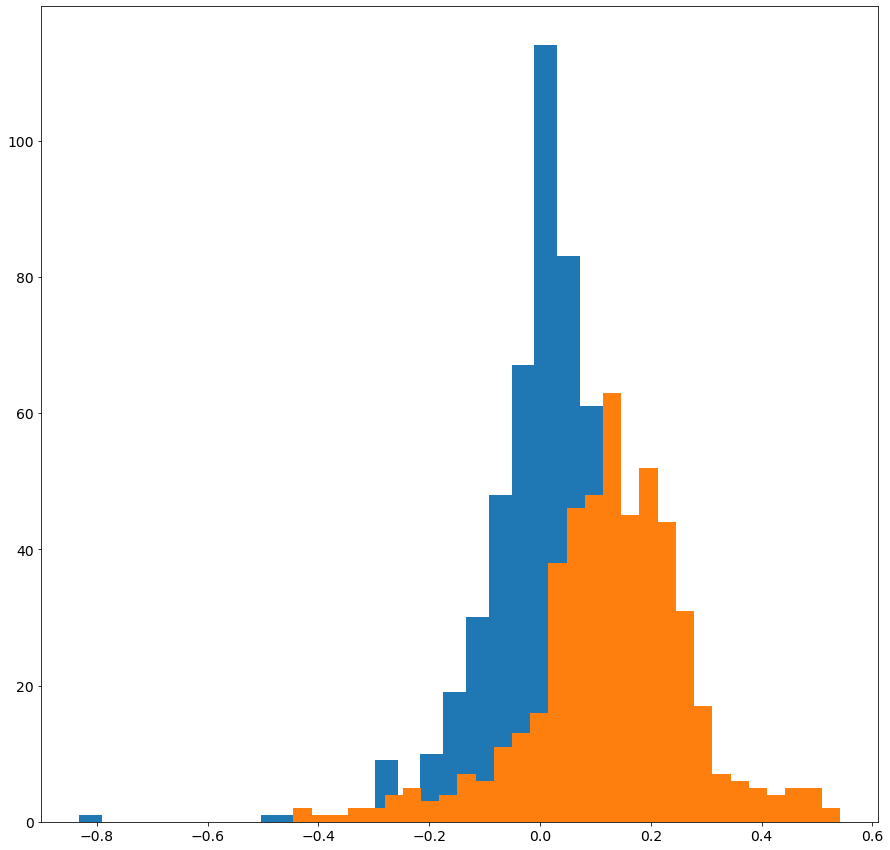

In [6]:
a = plt.hist(camels_df["CFE_error"], bins=30)
a = plt.hist(camels_df["LSTM_error"], bins=30)

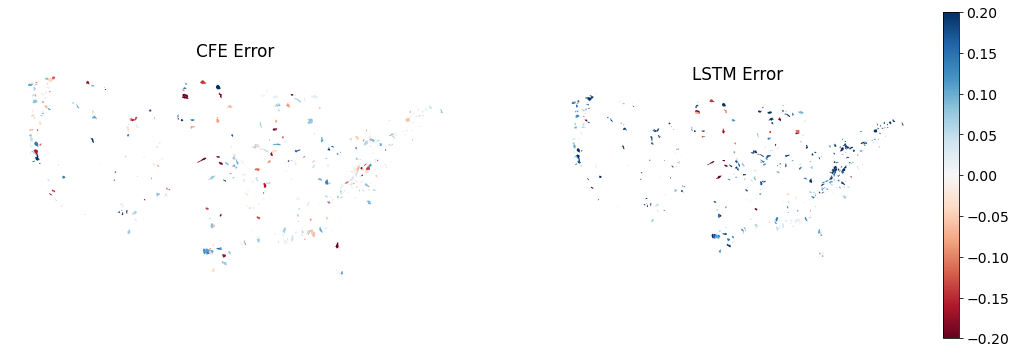

In [7]:
plt.rcParams['figure.figsize'] = (18, 6)

fig, axs = plt.subplots(1, 2)


axs[0] = camels_df.plot(column="CFE_error", vmin=-.2, vmax=.2, cmap='RdBu', ax=axs[0])
axs[0].set_title("CFE Error")
axs[1] = camels_df.plot(column="LSTM_error", legend=True, vmin=-.2, vmax=.2, cmap='RdBu', ax=axs[1])
axs[1].set_title("LSTM Error")
axs[0].set_axis_off()
axs[1].set_axis_off()